#**Recurrent NNs for Time Series Forecasting**

Download our weather forecasting dataset...

In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2022-03-01 17:48:31--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.11.78
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.11.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  18.8MB/s    in 0.7s    

2022-03-01 17:48:32 (18.8 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


Import the dataset...

In [2]:
import pandas as pd

df = pd.read_csv("jena_climate_2009_2016.csv") # Read in the CSV file.

temperature = df['T (degC)'].to_numpy() # Take the temperature column out.
raw_data = df.drop(labels=['Date Time'],axis=1) # Keep everything minus Date/Time, for use as predictors)

raw_data.describe() # This includes T (degC)

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


Plot the temperature time series... 

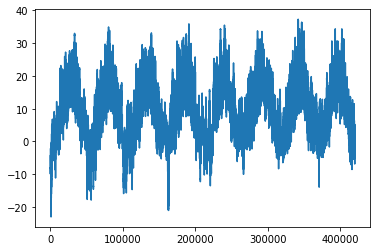

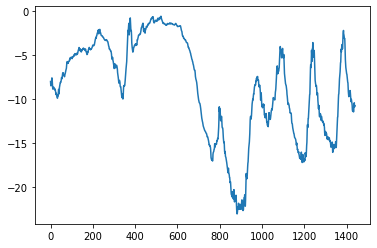

In [3]:
from matplotlib import pyplot as plt

plt.plot(range(len(temperature)),temperature)
plt.show()

plt.plot(range(1440),temperature[:1440])
plt.show()

In [4]:
num_train_samples = int(0.5 * len(temperature)) # First 50% of the temperature series.
num_val_samples = int(0.25 * len(temperature)) # Next 25% of the series.
num_test_samples = len(temperature) - num_train_samples - num_val_samples # Last 25% of the series.
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [5]:
import numpy as np

means = np.mean(raw_data)
raw_data = np.subtract(raw_data,means)

stds = np.std(raw_data)
raw_data = np.divide(raw_data,stds)

#*Create TF Time Series Datasets*

#seq = 3
#delay = 4的时候，就是前三个seq， 然后第四个是y， 然后下一次是2-4 是seq， 第五个是y， 以此类推。 shuffle的意思就是 把order 把indexshuffle一下 ，而不是打断其内部的顺序

This example will use tensorflow Dataset pipelines. In subsequent examples we will look at how you can work without these.

In [6]:
from tensorflow import keras

sampling_rate = 6 # The raw data has 6 measurements per hour; we will just use the first.
sequence_length = 120 # A given observation will include a 120 hour history of measurements (5 days)

# Delay = 6 * (120 + 24 - 1) = 143 * 6 = 858
# Delay length is our sequence length (in hours), plus a day. We multiply by 6 because there are 6 obs per hour in the data.
delay = sampling_rate * (sequence_length + 24 - 1) # Our predictions will be 24 hours beyond the end of our sequence. 

# We are going to work with 256 such series / sequences and associated targets at a time. 
batch_size = 256 
  
# We are going to build the first training dataset using obs 0 up to 210,225 through 
# Predictor data comes first, and will run up to 210,225 - 858 (we need to truncate early so we don't try to predict values beyond the end of the observation window.)
print(temperature[:num_train_samples-delay].shape)

# Shuffle means that values appearing in two adjacent sequence observations in the batch are not sequential in time.
# Note that using a tensorflow Dataset here means we don't have to create many redundant / overlapping copies of temperature time series / predictors in memory. 
# We will make a generator that pulls these series as needed, on demand.
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,  
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

# Same thing but using next 25% of samples.
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

# And the last 25% for test. 
test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

(209367,)


In [7]:
# We end up with 256 sequences of 120 hourly observations of 14 features, plus a target temperature that takes place 24 hours post.
for samples, targets in train_dataset:
     print("samples shape:", samples.shape)
     print("targets shape:", targets.shape)
     break

samples shape: (256, 120, 14)
targets shape: (256,)


#*Simple Benchmark: Prediction Using a 24 Hour Lag*

In [8]:
def evaluate_naive_method(dataset):
    total_abs_err = 0. # Start with 0 running error.
    samples_seen = 0 # Keep track of evaluated samples, so we an average later.
    for samples, targets in dataset:

        # The index [:, -1, 1] means all rows, the last measurement, the second column, i.e., T (degC). So, for every observation, we are grabbing the last obs of temperature in the training sequence.
        # Q: what are the multiplication and addition doing? 
        preds = samples[:, -1, 1] * stds[1] + means[1] # samples[:,-1,1] means all sequences, the last observed value, for the second feature (Temp)

        # Running abs error is absolute delta on predicted minus actual. We sum across all such errors in the batch.
        total_abs_err += np.sum(np.abs(preds - targets))

        # We update our running total of predictions. 
        samples_seen += samples.shape[0]

    # Lastly, take the average of all those absolute errors and return it. 
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset)}") 
print(f"Test MAE: {evaluate_naive_method(test_dataset)}")

Validation MAE: 2.4417357485655167
Test MAE: 2.6218984517612034


We can produce one off visual predictions based on this simple benchmark... re-running this code will iterate through the training data and show predictions and actuals.

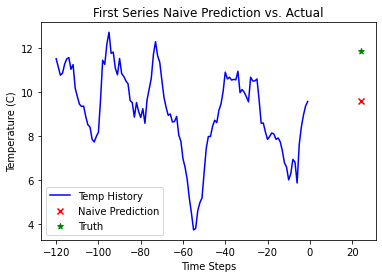

In [13]:
train_seqs = train_dataset.take(1)
for x,y in train_seqs:
  series = x[0,:,1] * stds[1] + means[1]
  pred = x[0,-1,1] * stds[1] + means[1]
  
  plt.title('First Series Naive Prediction vs. Actual')
  plt.xlabel('Time Steps')
  plt.ylabel('Temperature (C)')
  plt.plot(range(-120,0),series,c="b")
  plt.scatter(24,pred,c="r",marker="x")
  plt.scatter(24,y[0],c="g",marker="*")
  plt.legend(['Temp History','Naive Prediction','Truth'])
  plt.show()
  break

#*Basic Densely Connected Network*

In [14]:
from tensorflow import keras 
from tensorflow.keras import layers

# Q: why do we need to flatten the inputs? Is this not numeric data? What's going on? 
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
] 

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/10
819/819 [==============================] - 43s 50ms/step - loss: 11.6775 - mae: 2.6608 - val_loss: 10.1989 - val_mae: 2.5214
Epoch 2/10
819/819 [==============================] - 40s 49ms/step - loss: 8.9053 - mae: 2.3506 - val_loss: 10.3422 - val_mae: 2.5335
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 8.1532 - mae: 2.2459 - val_loss: 12.0090 - val_mae: 2.7559
Epoch 4/10
819/819 [==============================] - 41s 49ms/step - loss: 7.7249 - mae: 2.1876 - val_loss: 10.4074 - val_mae: 2.5432
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 7.3986 - mae: 2.1418 - val_loss: 10.3819 - val_mae: 2.5268
Epoch 6/10
819/819 [==============================] - 41s 50ms/step - loss: 7.1583 - mae: 2.1068 - val_loss: 12.1991 - val_mae: 2.7656
Epoch 7/10
819/819 [==============================] - 41s 50ms/step - loss: 6.9726 - mae: 2.0785 - val_loss: 10.8092 - val_mae: 2.5780
Epoch 8/10
819/819 [==============================] - 

Let's plot loss over training - our model appears incapable of learning much that is useful. 

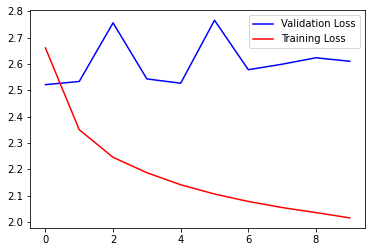

In [15]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()

#*CNN Using 1D Convolutions*

Just as a 2D Convolution Preserves Spatial Arrangements of pixel values, the 1D convolution preserves temporal arrangements of time series values. Instead of width and height, it focuses on a single dimension (time). This is useful if we expect generalizable, repeating patterns to appear across time series. Using a 1D Convolution with pooling layers, we can try to learn low-level intertemporal features that aggregate into higher-level temporal patterns that are perhaps useful for forecasting. 

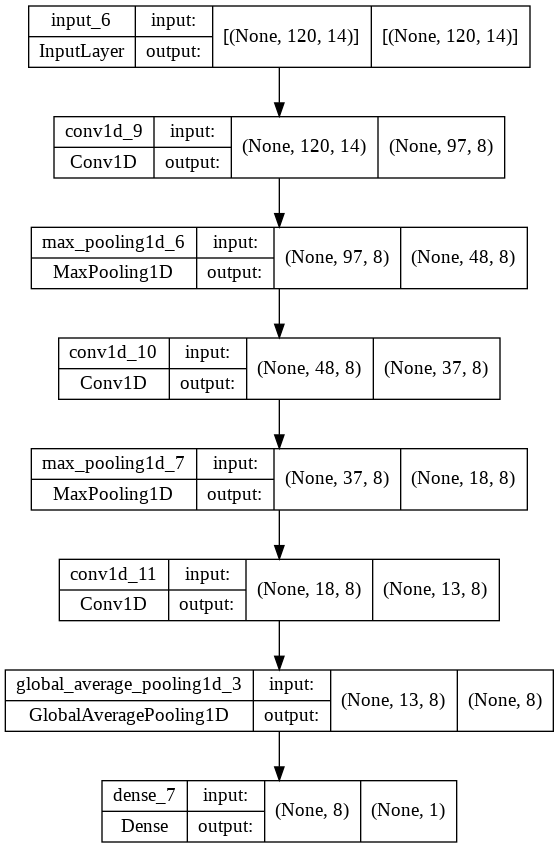

In [ ]:
# Recall that we start off with 120 observations of 14 channels (predictors)
# The Conv1D 'compresses' the 120x14 time series vectors into a lower-level embedding. 
# Note that 120 - 23 = 97 (the sliding window with no padding means we can only do 97 operations with our filter. 
# Output will be compressed signal length x number of kernels / filters, i.e., 97 x 8, for the first Convolution. 
# Note: We can't cleanly divide by 2 so we end up with 48 elements in each of our 8 feature maps after the first MaxPool.

inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs) # 1D Convolution with 8 channels / filters, and a window length of 24 (kernel size). Stride here is 1, no padding. 
x = layers.MaxPooling1D(2)(x) # Then we apply max pooling, with window of 2 (and stride of 2)
x = layers.Conv1D(16, 12, activation="relu")(x) # Then 8 filters again, window of 12. 
x = layers.MaxPooling1D(2)(x) # Pool by blocks of two values in each sequence (again, means we attempt to divide sequence length in half)
x = layers.Conv1D(32, 6, activation="relu")(x) # Again 8 filters, with sequence length of 6 this time.
x = layers.GlobalAveragePooling1D()(x) # We apply global average pooling to the resulting 8 feature maps (i.e., what high level patterns were more or less present across the series)
outputs = layers.Dense(1)(x) # Linear activation output.
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
keras.utils.plot_model(model,show_shapes=True)

Let's try fitting this CNN:

In [ ]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
  
model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/10
819/819 [==============================] - 48s 49ms/step - loss: 20.2398 - mae: 3.5211 - val_loss: 15.4999 - val_mae: 3.1065
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 14.3948 - mae: 3.0120 - val_loss: 19.1075 - val_mae: 3.4621
Epoch 3/10
819/819 [==============================] - 40s 49ms/step - loss: 13.3172 - mae: 2.8969 - val_loss: 14.0767 - val_mae: 2.9496
Epoch 4/10
819/819 [==============================] - 43s 52ms/step - loss: 12.6535 - mae: 2.8205 - val_loss: 14.4857 - val_mae: 3.0014
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 12.1762 - mae: 2.7637 - val_loss: 14.0264 - val_mae: 2.9584
Epoch 6/10
819/819 [==============================] - 44s 53ms/step - loss: 11.7722 - mae: 2.7187 - val_loss: 13.8059 - val_mae: 2.9399
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 11.4095 - mae: 2.6751 - val_loss: 13.5425 - val_mae: 2.9032
Epoch 8/10
819/819 [============================

Let's plot the resulting loss over training / validation. It performs pretty badly, because there are no 'persistent' patterns to learn here that generalize across different time windows. Essentially, the patterns in temperature variation differ across particular times of the day. The model is also unable to account for the fact that recent values should receive greater weight / attention than older values when making our prediction! And, the pooling steps are throwing out sequence information.  

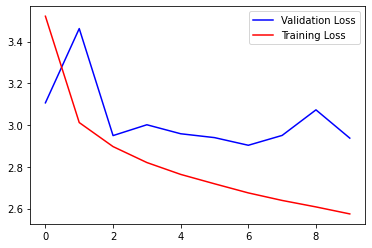

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Training Loss'])
plt.show()

#*RNN Using LSTM*

We will start off fitting LSTM, and then come back and look at the architecture.

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(3,return_sequences=True)(inputs) # 16,return_sequences=True
x = layers.LSTM(3)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras") 
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/10
819/819 [==============================] - 55s 60ms/step - loss: 111.4101 - mae: 8.4947 - val_loss: 88.8315 - val_mae: 7.4397
Epoch 2/10
819/819 [==============================] - 50s 61ms/step - loss: 68.1334 - mae: 6.3638 - val_loss: 53.4067 - val_mae: 5.5575
Epoch 3/10
819/819 [==============================] - 49s 59ms/step - loss: 40.6099 - mae: 4.7537 - val_loss: 30.7989 - val_mae: 4.0800
Epoch 4/10
819/819 [==============================] - 48s 59ms/step - loss: 24.1924 - mae: 3.6324 - val_loss: 18.6165 - val_mae: 3.1658
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 15.8911 - mae: 2.9952 - val_loss: 12.7400 - val_mae: 2.6731
Epoch 6/10
252/819 [========>.....................] - ETA: 23s - loss: 13.0165 - mae: 2.7625

KeyboardInterrupt: ignored

#比一开始的benchmark要好 - MAE低了  之前是2.63

Once again, we can plot the validation loss over training:

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Traiing Loss'])
plt.show()

#*Adding Recurrent Dropout or Regularizers*

The recurrent dropout is not implemented in a way that plays nicely with NVIDIA GPUs, so be aware that this model will train pretty slowly. A kernel regularizer may be preferable to mitigate overfitting, if it works.

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.LSTM(32,kernel_regularizer="l2")(inputs)# recurrent_dropout=0.25,unroll=True)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/10
819/819 [==============================] - 72s 85ms/step - loss: 27.6006 - mae: 3.8523 - val_loss: 10.0360 - val_mae: 2.4350
Epoch 2/10
819/819 [==============================] - 59s 71ms/step - loss: 14.7227 - mae: 2.9553 - val_loss: 9.7784 - val_mae: 2.4057
Epoch 3/10
 18/819 [..............................] - ETA: 32s - loss: 13.8625 - mae: 2.8597

KeyboardInterrupt: ignored

And let's visualize the loss over training once more... 

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Traiing Loss'])
plt.show()

Dropouts successfully mitigates overfitting, so now we can complicate the network by adding more filters / kernels, or by stacking more recurrent layers on top. To do the former, we need to pass the entire sequence of outputs from one layer to the next (return_sequences=True).

#*Stacked Recurrent Layers*

This model will get the MAE down to ~2.3 degrees, but it takes substantial time to train!

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[1]))
x = layers.GRU(32, return_sequences=True, kernel_regularizer="l1_l2")(inputs)# recurrent_dropout=0.5)(inputs)
x = layers.GRU(32, kernel_regularizer="l1_l2")(x)# recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
  
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]}")

Epoch 1/50
819/819 [==============================] - 50s 57ms/step - loss: 29.5933 - mae: 3.8176 - val_loss: 10.8990 - val_mae: 2.3410
Epoch 2/50
819/819 [==============================] - 48s 58ms/step - loss: 15.3816 - mae: 2.8897 - val_loss: 9.9578 - val_mae: 2.2822
Epoch 3/50
819/819 [==============================] - 47s 57ms/step - loss: 14.2098 - mae: 2.7937 - val_loss: 10.0435 - val_mae: 2.3271
Epoch 4/50
819/819 [==============================] - 47s 57ms/step - loss: 13.3450 - mae: 2.7201 - val_loss: 9.9905 - val_mae: 2.3149
Epoch 5/50
819/819 [==============================] - 48s 58ms/step - loss: 12.7226 - mae: 2.6600 - val_loss: 10.1121 - val_mae: 2.3567
Epoch 6/50
819/819 [==============================] - 47s 57ms/step - loss: 12.0938 - mae: 2.5950 - val_loss: 10.6642 - val_mae: 2.4210
Epoch 7/50
819/819 [==============================] - 47s 57ms/step - loss: 11.5230 - mae: 2.5316 - val_loss: 10.7529 - val_mae: 2.4512


KeyboardInterrupt: ignored

Let's once again plot the loss over training. 

In [ ]:
plt.plot(history.history['val_mae'],c="b")
plt.plot(history.history['mae'],c="r")
plt.legend(['Validation Loss','Traiing Loss'])
plt.show()